# Data Analysis Interview Challenge, Part 1: Exploratory Data Analysis

<span style="color:navy">
    <b>Instructions</b>: The attached <i>logins.json</i> file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.
</span>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

First, read the JSON file.

In [2]:
logins_df = pd.read_json(".\data\logins.json")

In [3]:
logins_df.shape

(93142, 1)

In [4]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


The timestamps look to be recorded in a 24-hour 'YYYY-MM-DD HH:MM:SS' format.

In [6]:
logins_df.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


The min value does not match the time at the first index, so the dataframe will be sorted.

In [7]:
logins_df = logins_df.sort_values('login_time')
logins_df.head(10)

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37
5,1970-01-01 20:21:41
10,1970-01-01 20:26:05
4,1970-01-01 20:26:21
11,1970-01-01 20:31:03
12,1970-01-01 20:34:46


In [8]:
logins_df.nunique()

login_time    92265
dtype: int64

Although there are 93,142 logins, there are only 92,265 logins, so 877 logins occur at the same time.

## 15-minute Interval Aggregation

In [9]:
max_datetime = logins_df['login_time'].max()
min_datetime = logins_df['login_time'].min()
print("{} = ({}) - ({})".format(max_datetime - min_datetime, max_datetime, min_datetime))

101 days 22:45:22 = (1970-04-13 18:57:38) - (1970-01-01 20:12:16)


In [10]:
# days * hours_per_day * min_per_hour / 15 minutes
102*24*60/15

9792.0

In [11]:
len(pd.date_range(start=min_datetime, end=max_datetime, freq='15T'))

9788

The range is almost 102 days, so in 15 minute increments, the number of rows should equate to a little under 9792, or more precisely to our dataset, we can check using `pd.date_range()`, which resulted in 9788 rows. Next, we can use Pandas's handy [`resample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) method.

In [12]:
# Setting origin='start' means that we start grouping the logins into 15-minute increments from the start of our dataset,
# which is our .min(), 1970-01-01 20:12:16.
logins_15m_df = logins_df.resample('15T', on='login_time', origin='start').count()
logins_15m_df.head()

,login_time
login_time,
1970-01-01 20:12:16,8
1970-01-01 20:27:16,8
1970-01-01 20:42:16,6
1970-01-01 20:57:16,3
1970-01-01 21:12:16,3


In [13]:
logins_15m_df.rename(columns={'login_time':'logins_per_15m'}, inplace=True)

In [14]:
logins_15m_df['logins_per_15m'].describe()

count    9788.000000
mean        9.515938
std         8.353281
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        71.000000
Name: logins_per_15m, dtype: float64

In [40]:
logins_15m_df[logins_15m_df['logins_per_15m'] == 71]

,logins_per_15m,month,day,hour,min,dow
login_time,,,,,,
1970-03-01 04:27:16,71,3,1,4,27,6


<AxesSubplot:>

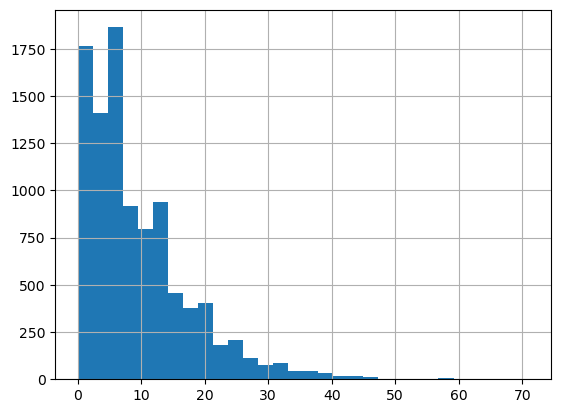

In [120]:
logins_15m_df['logins_per_15m'].hist(bins=30)

In [16]:
logins_15m_df['month'] = logins_15m_df.index.month
logins_15m_df['day'] = logins_15m_df.index.day
logins_15m_df['hour'] = logins_15m_df.index.hour
logins_15m_df['dow'] = logins_15m_df.index.day_of_week

In [17]:
logins_15m_df.head()

,logins_per_15m,month,day,hour,min,dow
login_time,,,,,,
1970-01-01 20:12:16,8,1,1,20,12,3
1970-01-01 20:27:16,8,1,1,20,27,3
1970-01-01 20:42:16,6,1,1,20,42,3
1970-01-01 20:57:16,3,1,1,20,57,3
1970-01-01 21:12:16,3,1,1,21,12,3


In [18]:
logins_15m_df.tail()

,logins_per_15m,month,day,hour,min,dow
login_time,,,,,,
1970-04-13 17:57:16,4,4,13,17,57,0
1970-04-13 18:12:16,4,4,13,18,12,0
1970-04-13 18:27:16,5,4,13,18,27,0
1970-04-13 18:42:16,7,4,13,18,42,0
1970-04-13 18:57:16,1,4,13,18,57,0


## Visualizations

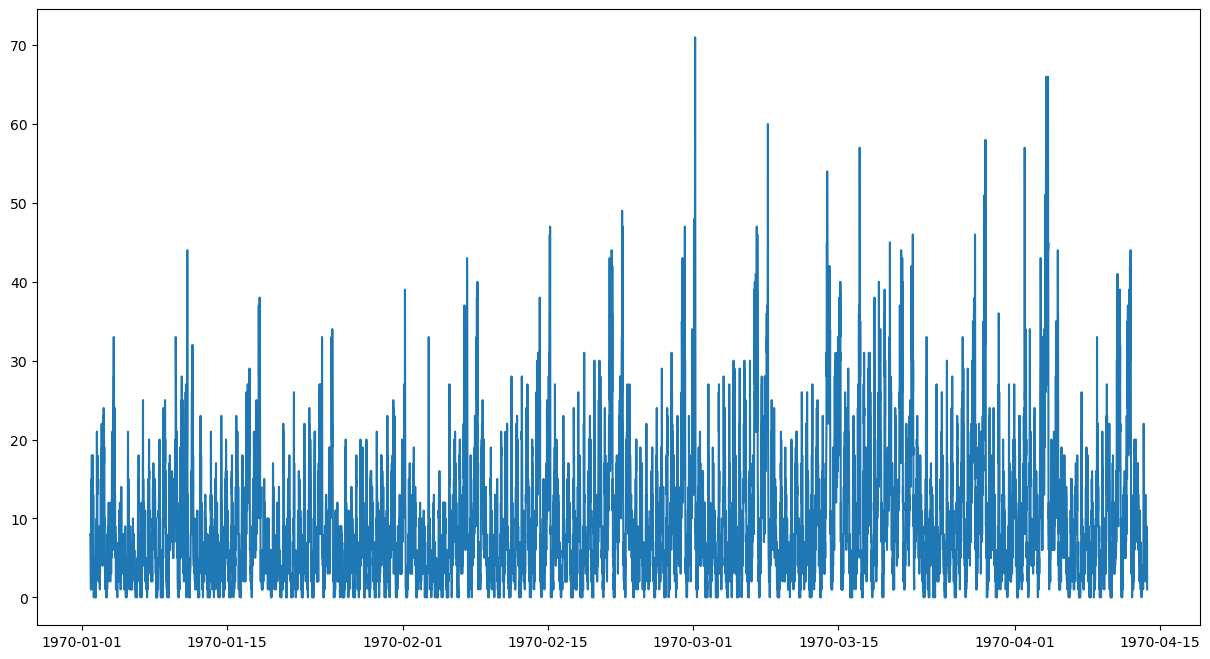

In [19]:
plt.figure(figsize=(15,8))
plt.plot(logins_15m_df.index, logins_15m_df.logins_per_15m)

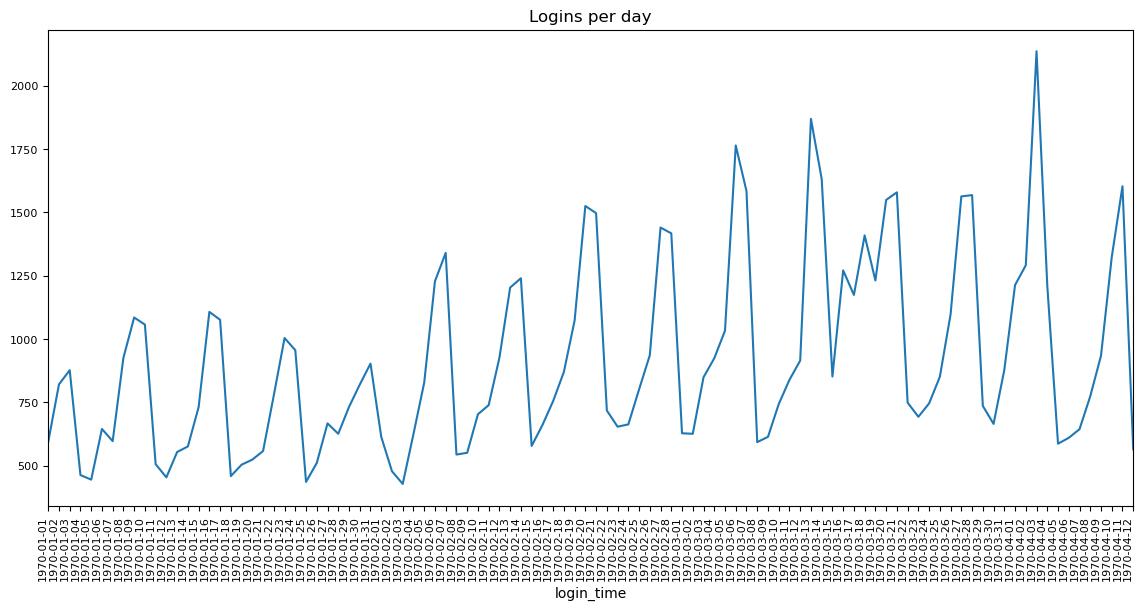

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
ax = logins_15m_df['logins_per_15m'].resample('D', origin='start').sum() \
        .plot(kind='line', title='Logins per day',
              xticks=logins_15m_df['logins_per_15m'].resample('D', origin='start').sum().index,
              rot=90,
              xlim=(logins_15m_df['logins_per_15m'].resample('D', origin='start').sum().index.min(),logins_15m_df['logins_per_15m'].resample('D', origin='start').sum().index.max()),
              fontsize=8)

<AxesSubplot:xlabel='login_time'>

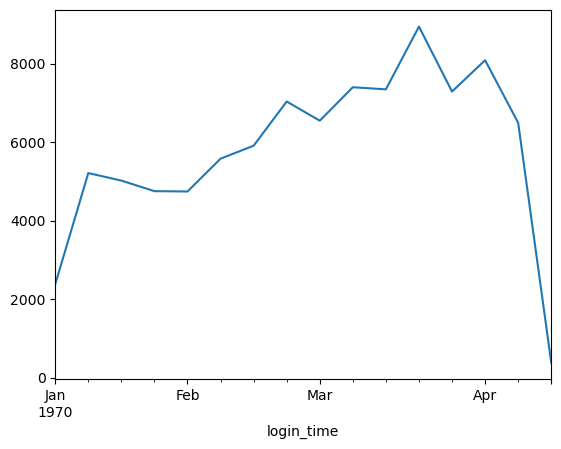

In [127]:
logins_15m_df['logins_per_15m'].resample('W', origin='start').sum().plot()

<AxesSubplot:xlabel='login_time'>

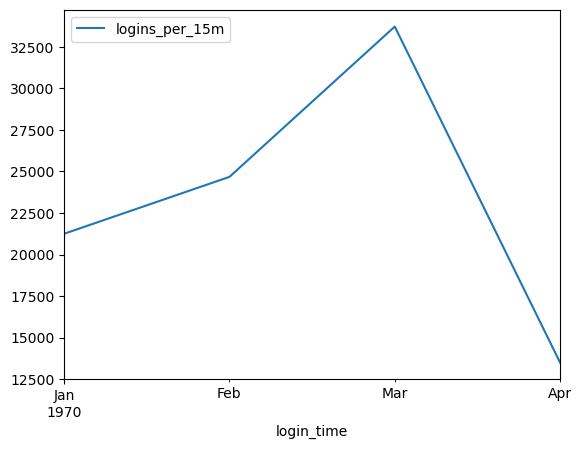

In [22]:
logins_15m_df[['logins_per_15m']].resample('M', origin='start').sum().plot()

In [23]:
logins_15m_df.groupby('month').sum()['logins_per_15m']

month
1    21250
2    24674
3    33725
4    13493
Name: logins_per_15m, dtype: int64

<AxesSubplot:xlabel='day'>

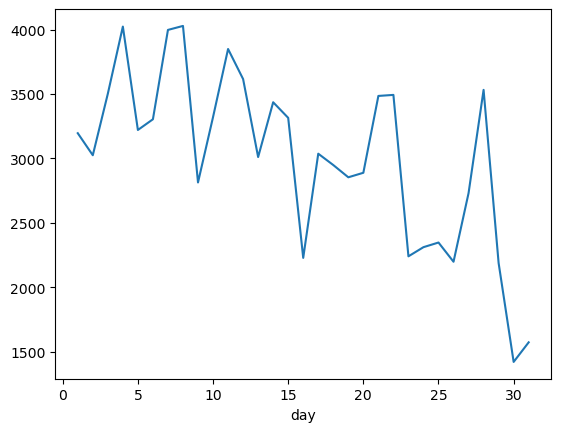

In [24]:
logins_15m_df.groupby('day').sum()['logins_per_15m'].plot()

Earlier days of the month had the most logins, but keep in mind that our dataset ended about halfway through the month of April. February also has fewer days. A graph by days of the month is not that useful.

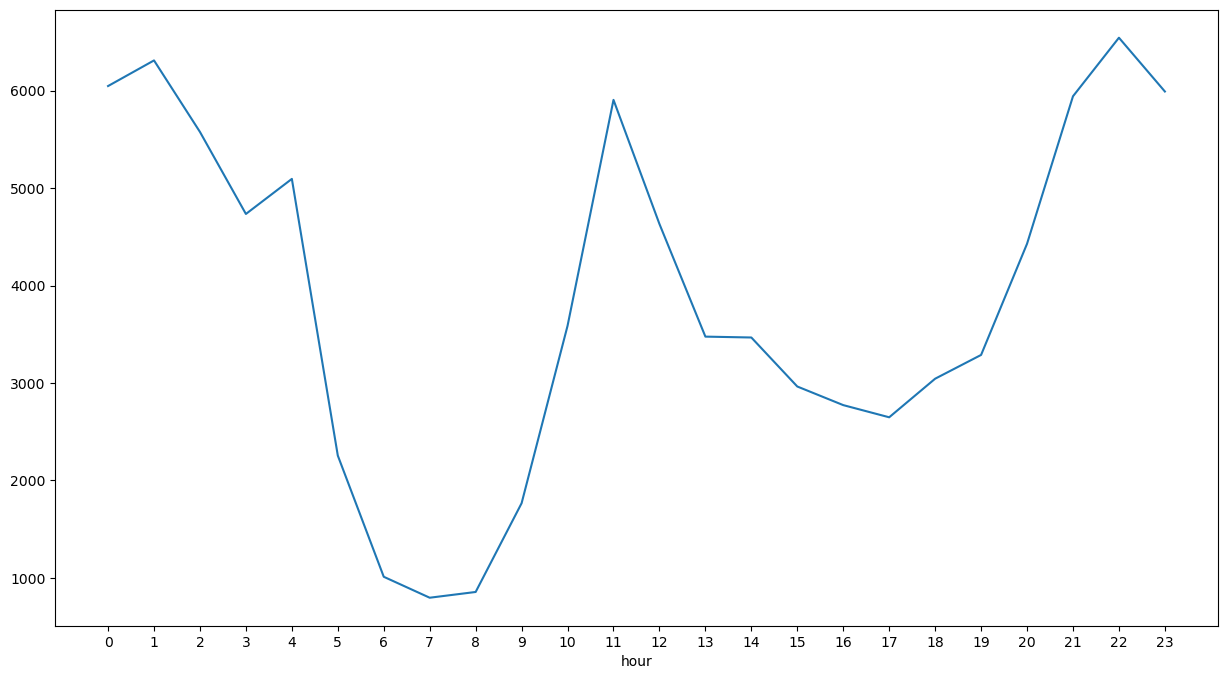

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax = logins_15m_df.groupby('hour').sum()['logins_per_15m'].plot()
_ = ax.set_xticks([h for h in range(0,24)])

For whatever reason, people log in at ridiculous hours of the night and midday, but not so much in the hours of 6-8.

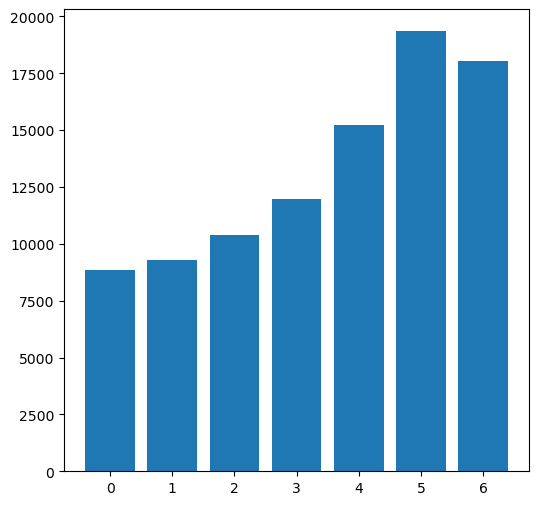

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
_ = ax.bar(logins_15m_df.groupby('dow').sum()['logins_per_15m'].index, logins_15m_df.groupby('dow').sum()['logins_per_15m'].values)
plt.show()
#logins_15m_df.groupby('dow').sum()['logins_per_15m'].values

Mondays had the lowest overall number of logins, and Saturday had the most.

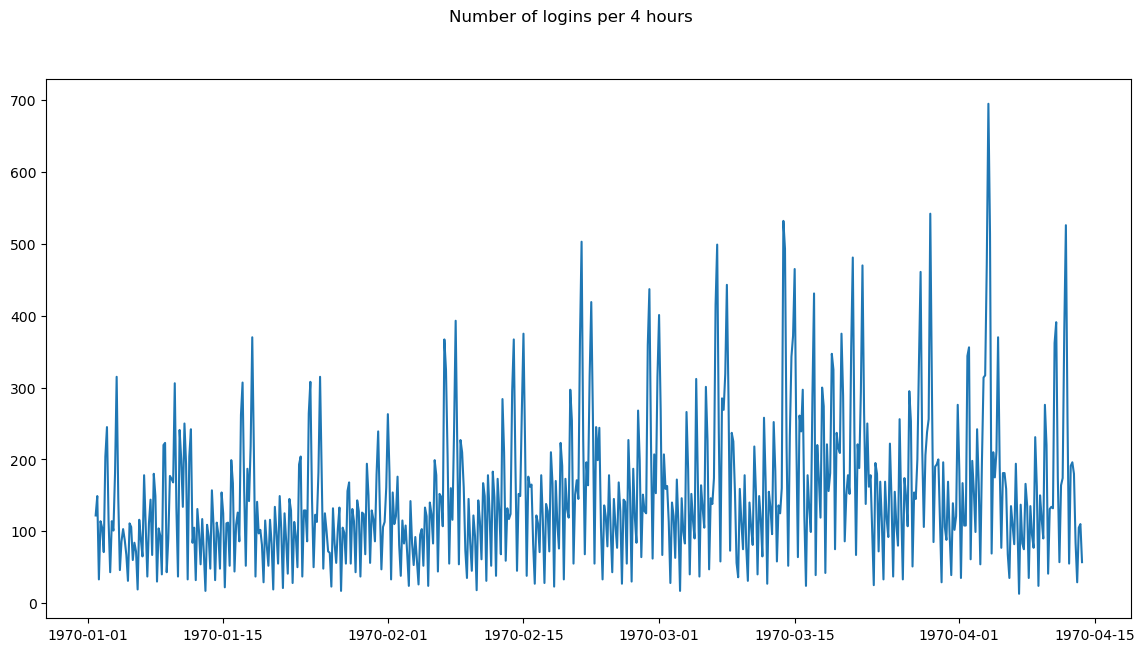

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
_ = ax.plot(logins_15m_df[['logins_per_15m']].resample('4H', origin='start').sum().index,
             logins_15m_df[['logins_per_15m']].resample('4H', origin='start').sum())
_ = fig.suptitle("Number of logins per 4 hours")

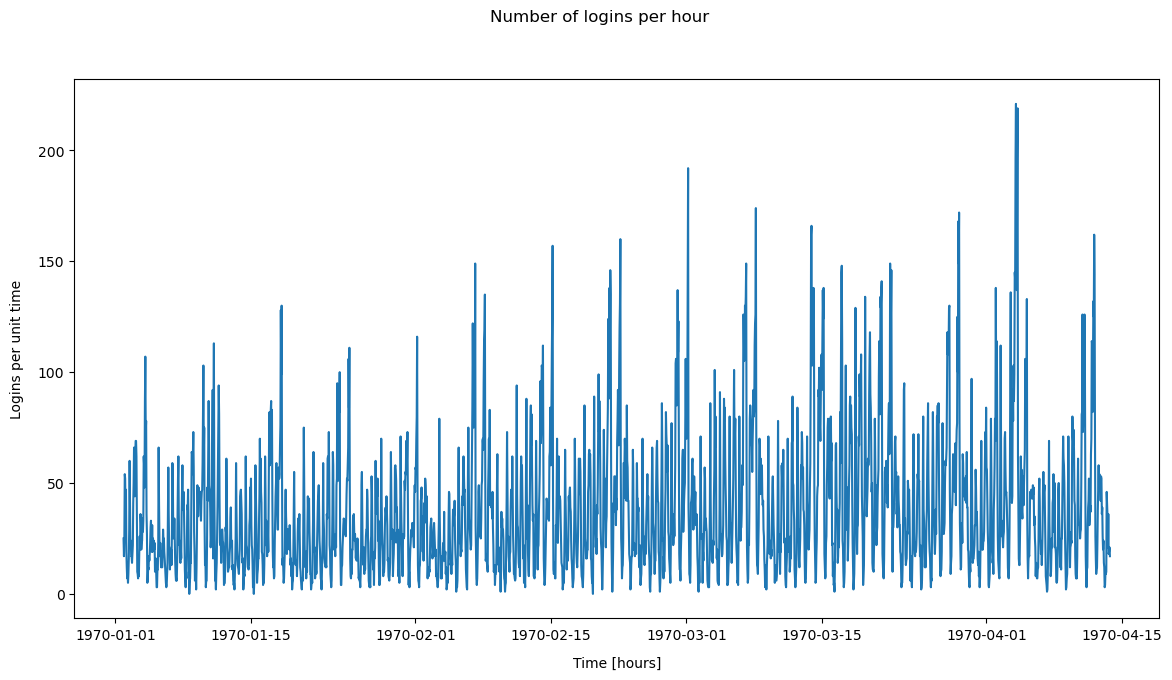

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
_ = ax.plot(logins_15m_df[['logins_per_15m']].resample('H', origin='start').sum().index,
             logins_15m_df[['logins_per_15m']].resample('H', origin='start').sum())
_ = ax.set_xlabel("Time [hours]", labelpad=10)
_ = ax.set_ylabel("Logins per unit time", labelpad=10)
_ = fig.suptitle("Number of logins per hour")

The daily and hourly sampled series suggest that there seems to be a seasonality, and the variation of the seasons may be increasing over time. There may be a very gradual increase in logins overall, but it is very slight and may be hard to tell from only 3 months of data.

Let's guess the season is 7 days (1 week).

In [146]:
logins_per_day = pd.DataFrame(logins_15m_df['logins_per_15m'].resample('D', origin='start').sum())

In [149]:
logins_per_day.rename(columns={'logins_per_15m':'logins_per_day'}, inplace=True)
logins_per_day

,logins_per_day
login_time,
1970-01-01 20:12:16,594
1970-01-02 20:12:16,821
1970-01-03 20:12:16,877
1970-01-04 20:12:16,463
1970-01-05 20:12:16,445
...,...
1970-04-08 20:12:16,774
1970-04-09 20:12:16,934
1970-04-10 20:12:16,1323


In [157]:
logins_per_day['cma_7_trend'] = logins_per_day['logins_per_day'].rolling(window=7, center=True).mean()

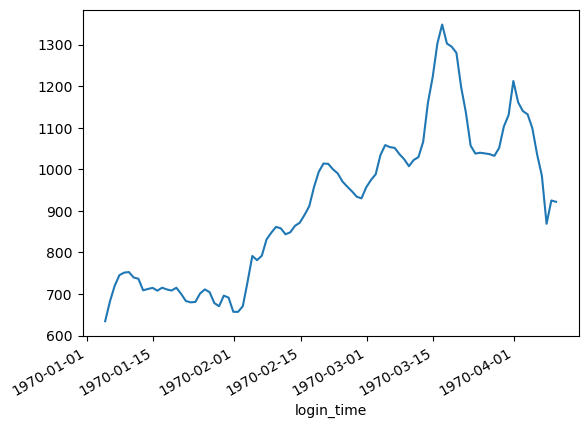

In [158]:
fig = plt.figure()
fig.suptitle("TODO")
logins_per_day['cma_7_trend'].plot()
plt.show()

As mentioned before, the seasonal variations seem to change with the trend, so perhaps it is multiplicative.

In [160]:
logins_per_day['seasonality_noise'] = logins_per_day['logins_per_day'] / logins_per_day['cma_7_trend']

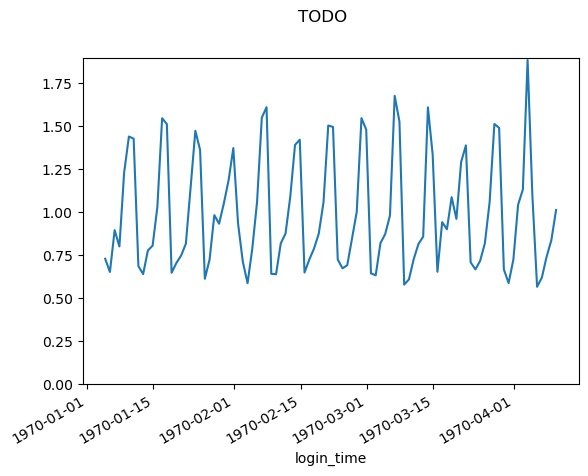

In [226]:
fig = plt.figure()
fig.suptitle("TODO")
plt.ylim(0,1.9)
logins_per_day['seasonality_noise'].plot()
plt.show()

In [189]:
logins_per_day['dow'] = logins_per_day.index.day_of_week

In [190]:
logins_per_day

,logins_per_day,cma_7_trend,seasonality_noise,dow
login_time,,,,
1970-01-01 20:12:16,594,NaN,NaN,3
1970-01-02 20:12:16,821,NaN,NaN,4
1970-01-03 20:12:16,877,NaN,NaN,5
1970-01-04 20:12:16,463,634.571429,0.729626,6
1970-01-05 20:12:16,445,682.000000,0.652493,0
...,...,...,...,...
1970-04-08 20:12:16,774,925.000000,0.836757,2
1970-04-09 20:12:16,934,921.857143,1.013172,3
1970-04-10 20:12:16,1323,NaN,NaN,4


In [221]:
dow_avg = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
dow_inc = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}

for i in range(0, logins_per_day['seasonality_noise'].size):
    if ~np.isnan(logins_per_day['seasonality_noise'][i]):
        dow_avg[logins_per_day['dow'][i]] += logins_per_day['seasonality_noise'][i]
        dow_inc[logins_per_day['dow'][i]] += 1

for i in range(0,7):
    dow_avg[i] /= dow_inc[i]

logins_per_day['seasonality'] = np.nan

for i in range (0, logins_per_day['seasonality_noise'].size):
    if ~np.isnan(logins_per_day['seasonality_noise'][i]):
        #logins_per_day['seasonality'][i] = dow_avg[logins_per_day['dow'][i]]
        #logins_per_day.iloc[i]['seasonality'] = dow_avg[logins_per_day['dow'][i]]
        logins_per_day.iloc[i,4] = dow_avg[logins_per_day['dow'][i]]
        #print(dow_avg[logins_per_day['dow'][i]])

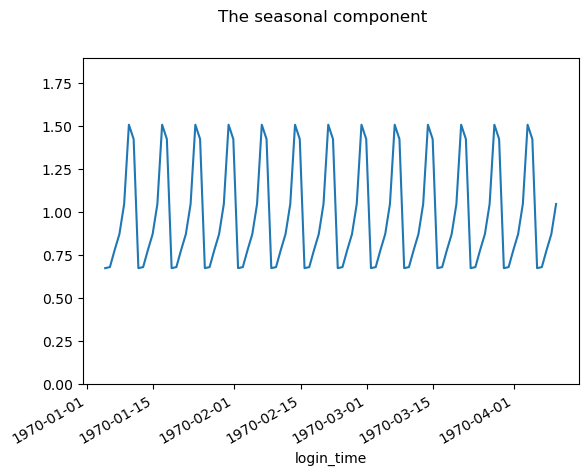

In [225]:
fig = plt.figure()
fig.suptitle('The seasonal component')
plt.ylim(0,1.9)
logins_per_day['seasonality'].plot()
plt.show()

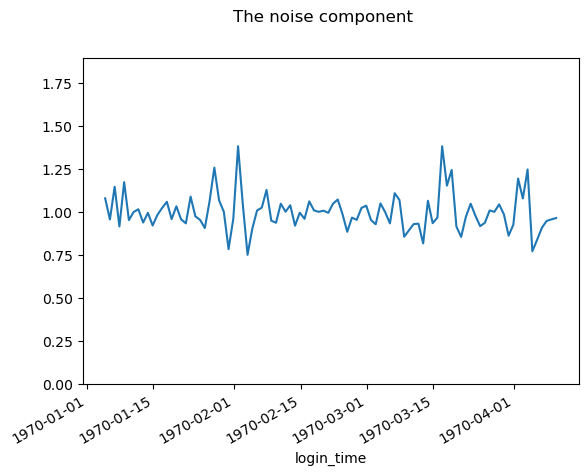

In [227]:
logins_per_day['noise'] = logins_per_day['seasonality_noise'] / logins_per_day['seasonality']

fig = plt.figure()
fig.suptitle('The noise component')
plt.ylim(0,1.9)
logins_per_day['noise'].plot()
plt.show()

In [228]:
from statsmodels.tsa.stattools import kpss
kpss(logins_per_day['logins_per_day'])

C:\Users\chian\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.180985354924946,
 0.01,
 3,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

<AxesSubplot:xlabel='login_time'>

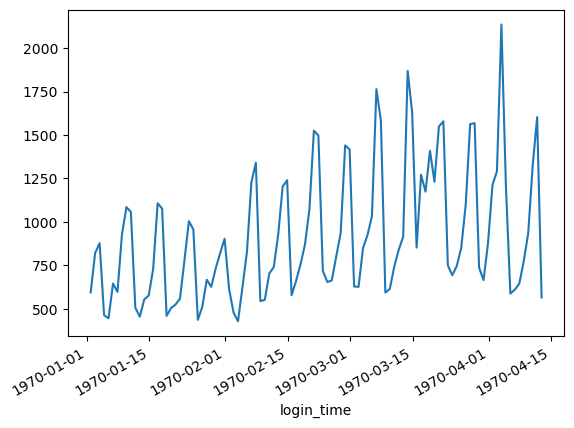

In [229]:
logins_per_day['logins_per_day'].plot()

In [230]:
y_log = np.log(logins_per_day['logins_per_day'])

<AxesSubplot:xlabel='login_time'>

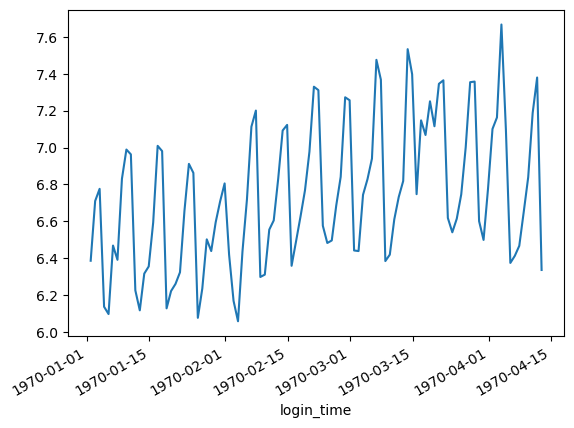

In [231]:
y_log.plot()

In [238]:
from statsmodels.tsa.stattools import kpss
kpss(y_log.diff().dropna()) # p-value is the second value

C:\Users\chian\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.08846190445202076,
 0.1,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

<AxesSubplot:xlabel='login_time'>

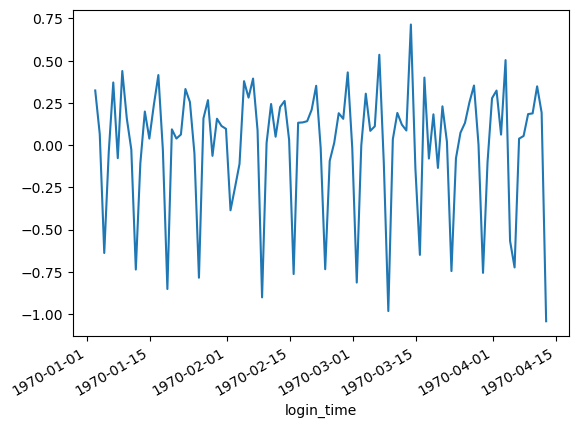

In [239]:
y_log.diff().dropna().plot()

In [246]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

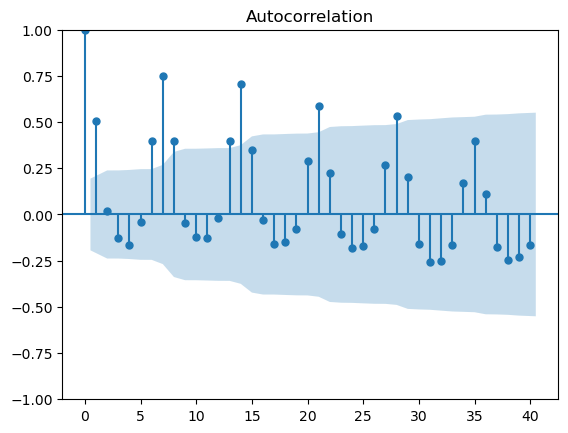

In [266]:
plot_acf(logins_per_day['logins_per_day'], lags=40, alpha=0.05)
plt.show()

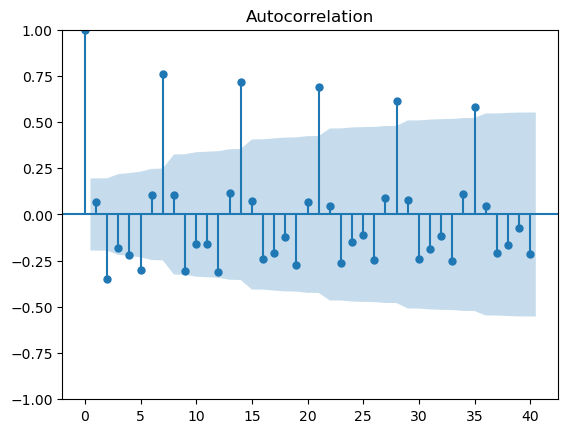

In [267]:
plot_acf(y_log.diff().dropna(), lags=40, alpha=0.05)
plt.show()

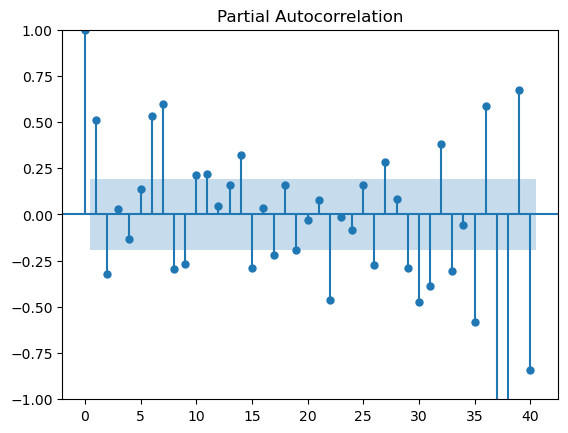

In [269]:
plot_pacf(logins_per_day['logins_per_day'], lags=40, alpha=0.05)
plt.show()

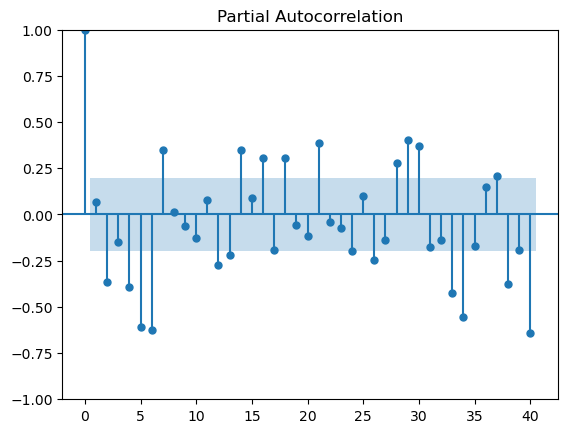

In [270]:
plot_pacf(y_log.diff().dropna(), lags=40, alpha=0.05)
plt.show()

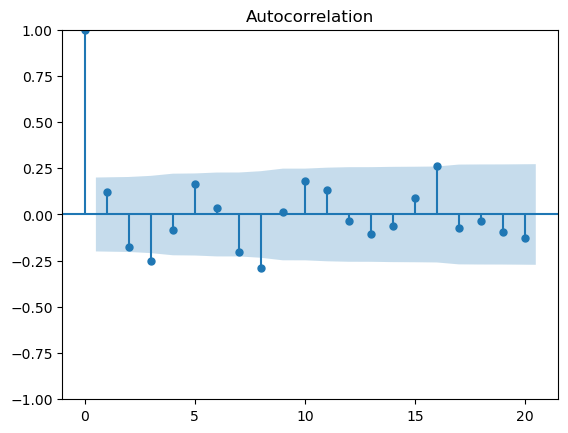

In [271]:
plot_acf(logins_per_day['noise'].dropna(), lags=20, alpha=0.05)
plt.show()

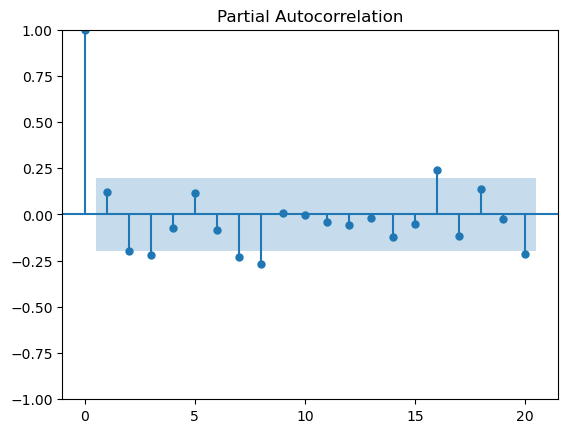

In [272]:
plot_pacf(logins_per_day['noise'].dropna(), lags=20, alpha=0.05)
plt.show()